In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
file_path = file_path = '/content/drive/MyDrive/Project/processed_dataset.csv'
df = pd.read_csv(file_path)

df = pd.read_csv(file_path)

print("Dataset loaded permanently from Google Drive!")
df.head()

Dataset loaded permanently from Google Drive!


,InvoiceDate,Revenue,DayOfWeek,Month,Quarter,Year,Revenue_Scaled
0,2009-12-01,54351.23,1,12,4,2009,0.270513
1,2009-12-02,63172.58,2,12,4,2009,0.314418
2,2009-12-03,73972.45,3,12,4,2009,0.368171
3,2009-12-04,40582.32,4,12,4,2009,0.201984
4,2009-12-05,9803.05,5,12,4,2009,0.048791


In [4]:

#  SETUP AND DATA SPLITTING (DECISION TREE REGRESSOR)


# Importing the main libraries for data handling, modeling, and evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. DEFINE FEATURES AND TARGET
# Target is the continuous 'Revenue' column
# Target column (the output we want to predict)
TARGET_NAME = 'Revenue'

# Input features (the factors used to predict Revenue)
FEATURE_COLUMNS = ['DayOfWeek', 'Month', 'Quarter', 'Year']

# Create X (inputs) and y (output)
X = df[FEATURE_COLUMNS]
y = df[TARGET_NAME]

# Store feature names (useful later for display or debugging)
FEATURE_NAMES = X.columns.tolist()

# 2. TRAIN/TEST SPLIT

# Split data into training (80%) and testing (20%) parts
# The model learns from training data and is evaluated on unseen test data
RANDOM_SEED = 42  # Ensures same random split every time
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Display how many samples went into each set
print(f"Data split completed. Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Data split completed. Training samples: 591, Test samples: 148


In [5]:
# ==============================================================================
# BLOCK 2: BASELINE MODEL AND CROSS-VALIDATION
# ==============================================================================
from sklearn.model_selection import cross_val_score

# 1. BASELINE MODEL: Decision Tree Regressor

# Create a simple Decision Tree model with limited depth.
# A small depth avoids overfitting (memorizing training data).
dt_model_baseline = DecisionTreeRegressor(max_depth=5, random_state=42)

# Train the model on the training data
dt_model_baseline.fit(X_train, y_train)

# Perform 5-Fold Cross-Validation on the training set using R-squared
# Perform 5-fold cross-validation to check model consistency.
# It splits training data into 5 parts — trains on 4 and tests on 1 repeatedly.
cv_scores = cross_val_score(dt_model_baseline, X_train, y_train, cv=5, scoring='r2')

# Display the average R² score from the 5 folds
print(f"\nBaseline Average CV R-squared: {np.mean(cv_scores):.4f}")


Baseline Average CV R-squared: 0.5045


In [6]:
# ==============================================================================
# BLOCK 3: HYPERPARAMETER TUNING (GRID SEARCH)
# ==============================================================================
from sklearn.model_selection import GridSearchCV

# Tuning for pruning: max_depth limits tree complexity, min_samples_leaf smooths results
# Define which hyperparameters to test.
# max_depth controls tree size, min_samples_leaf controls smoothness.
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20],
}
# Calculate total number of combinations (4 x 3 = 12)
TOTAL_VARIETIES = len(param_grid['max_depth']) * len(param_grid['min_samples_leaf'])

# Setup Grid Search using Negative Mean Squared Error (scoring for regression tuning)
# Setup Grid Search with 5-fold cross-validation
# scoring='neg_mean_squared_error' means we minimize error (smaller = better)
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)


# Run the grid search — fits all model variations and finds the best one
grid_search_dt.fit(X_train, y_train)


# Show results
print(f"\nTuning Complete. Total {TOTAL_VARIETIES} varieties tested.")
print(f"Best Hyperparameters found: {grid_search_dt.best_params_}")
print(f"Best Cross-Validation Score (Negative MSE): {grid_search_dt.best_score_:.2f}")


Tuning Complete. Total 12 varieties tested.
Best Hyperparameters found: {'max_depth': 5, 'min_samples_leaf': 10}
Best Cross-Validation Score (Negative MSE): -234816504.65


In [7]:
# ======================================================================
# STEP 5 — FINAL EVALUATION ON UNSEEN TEST DATA
# ======================================================================
from sklearn.metrics import mean_absolute_error

# 1. FINAL MODEL SELECTION
final_dt_model = grid_search_dt.best_estimator_

# 2. MAKE PREDICTIONS
y_pred_dt = final_dt_model.predict(X_test)

# 3. CALCULATE METRICS
final_r2 = r2_score(y_test, y_pred_dt)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
final_mae = mean_absolute_error(y_test, y_pred_dt)  # ✅ Added MAE

# 4. DISPLAY RESULTS
print(f"\n--- FINAL DECISION TREE REGRESSION TEST RESULTS ---")
print(f"Test R-squared (R²): {final_r2:.4f}")
print(f"Test Root Mean Squared Error (RMSE): {final_rmse:.2f}")
print(f"Test Mean Absolute Error (MAE): {final_mae:.2f}")



--- FINAL DECISION TREE REGRESSION TEST RESULTS ---
Test R-squared (R²): 0.6200
Test Root Mean Squared Error (RMSE): 13898.04
Test Mean Absolute Error (MAE): 8920.97


Plot saved as actual_vs_predicted_dt.png


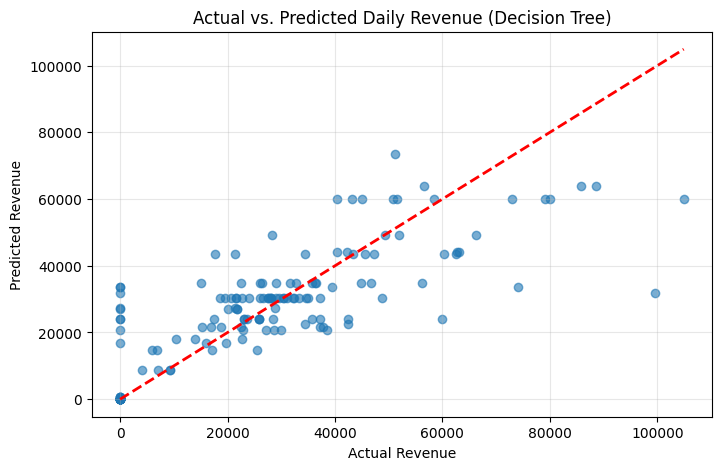

In [8]:
# ==============================================================================
# BLOCK 5: VISUALIZATION (ACTUAL VS. PREDICTED)
# ==============================================================================

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure size for the plot
plt.figure(figsize=(8, 5))

# Create scatter plot: Actual Revenue (x-axis) vs Predicted Revenue (y-axis)
plt.scatter(y_test, y_pred_dt, alpha=0.6)

# Plotting the ideal line (where Actual = Predicted
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# chart title and axis labels
plt.title('Actual vs. Predicted Daily Revenue (Decision Tree)')
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')

# Add a light grid for better readability
plt.grid(True, alpha=0.3)

# Save the plot as a PNG image file
plt.savefig('actual_vs_predicted_dt.png')
print("Plot saved as actual_vs_predicted_dt.png")